# Figure 3. Rare variant results

### Dependencies

In [1]:
import os
import glob
import re

import pandas as pd
import numpy as np
import scipy.io as sio
import scipy.stats as stats
from statsmodels.nonparametric.kernel_regression import KernelReg

import seaborn as sns
import matplotlib.pyplot as plt

from nilearn import plotting, image
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

### Plotting 

In [2]:
def load_column_names_first_line(fn):
    return [str(x) for x in open( fn ).read().split('\n')[0].split("\t") ]

def load_column_names(fn):
    return [str(x) for x in open( fn ).read().split('\n')[:-1] ] 

def get_edge_names(list_names):
    """
    Returns edge combinations for edges
    """
    df_names=pd.DataFrame(index=list_names, columns=list_names)
    for i in range(len(list_names)):
        for j in range(len(list_names)):
            df_names.iloc[i, j] = list_names[i]+"*"+list_names[j]
            
    #heritable = load_column_names("/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges.txt") + load_column_names("/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges_asym.txt")
    #heritable = ["sent_edges_"+x for x in heritable]
    
    return [x for x in list(df_names.to_numpy()[np.triu_indices(len(list_names), k=1)].flatten()) if x in heritable]


def get_idx(cat):
    """
    Returns indices for category
    """
    sent_core_l_ind = [2, 30, 32, 40, 56, 98, 102, 146, 148, 166, 168, 170, 172, 174, 182, 184, 222, 224]
    sent_core_r_ind = [3, 31, 33, 41, 57, 99, 103, 147, 149, 167, 169, 171, 173, 175, 183, 185, 223, 225]
    sent_core_bi_ind = sorted(sent_core_l_ind + sent_core_r_ind)
    
    if cat == "edges":
        return sent_core_bi_ind
    elif cat == "edges_HD":
        return sent_core_l_ind
    
    
def set_up_coordinates(cat):
    """
    get coordinates for plot
    """
    #set up atlas + coordinates
    aicha_atlas = "/data/workspaces/lag/workspaces/lg-ukbiobank/projects/multilateral/FuncNet_AICHA/segs/AICHA.nii"
    aicha_img = image.load_img(aicha_atlas)
    aicha_coords = plotting.find_parcellation_cut_coords(aicha_img)
    
    #indices
    idx = get_idx(cat)

    #get coordinates and names
    return aicha_coords[idx, :]

def get_names_aicha(cat):
    """
    Return node names
    """
    aicha_test = "/data/clusterfs/lag/projects/lg-ukbiobank/working_data/imaging_data/AICHA/1000099/AICHA_timeseries_NO_GSR_cormat.txt"
    aicha2 = pd.read_csv(aicha_test, sep=";", index_col=0)
    
    idx = get_idx(cat)
    
    if cat == "edges":
        return list(aicha2.columns[idx]) #[x for x in list(aicha2.columns[idx]) if x in heritable]
    elif cat == "edges_HD":
        return list(x[:-2] for x in aicha2.columns[idx]) #[x for x in list(aicha2.columns[idx]) if x in heritable]


def make_nice_mat(input_data, cat, var_name):
    """
    put data from column into right spot in matrix
    """
    #get indices
    ind_names = get_names_aicha(cat)
        
    #set up dataframe
    df_out = pd.DataFrame(index=ind_names, columns=ind_names)
    df_out.iloc[np.diag_indices(len(ind_names)), np.diag_indices(len(ind_names))] = 0
    
    #put data in right place
    for x in list(input_data.columns):
        nodes = x.split("*", 1)
        df_out.loc[nodes[0], nodes[1]] = input_data.loc[var_name, x]
        df_out.loc[nodes[1], nodes[0]] = input_data.loc[var_name, x]
    
    return df_out
        
    
def plot_results_brain_betas(betas, pvals, cat, snp, title, vmax_in=None, alpha=None, ax=None, out=None, rare=False):
    """
    Main function:
    - loads data
    - significance testing
    - plot using nilearn
    """
    #get correlation values
    beta_mat = make_nice_mat(betas, cat, snp)
    
    if alpha:
        p_mat = make_nice_mat(pvals, cat, snp)
        beta_mat = beta_mat[p_mat < alpha]
        
    if vmax_in is None:
        vmax_in = np.max(np.max(beta_mat))
    
    #plot
    if np.abs(beta_mat.sum().sum()) < 0.0001:
        plotting.plot_markers([1]*len(beta_mat),
                              set_up_coordinates(cat), 
                              node_cmap="binary",
                              node_size=30,
                              alpha=0.8, 
                              display_mode='lyrz',
                              title=title, 
                              colorbar=False,
                              axes=ax)
        
    else:
        if rare:
            colors = ["whitesmoke", "indianred"]
            cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)
            
            plotting.plot_connectome(beta_mat.to_numpy(dtype=float),
                             set_up_coordinates(cat),
                             title=title,
                             edge_cmap=cmap1,
                             edge_vmin=0,
                             edge_vmax=vmax_in,
                             node_color="dimgrey",
                             node_size=30,
                             display_mode="lyrz",
                             colorbar=True,
                             alpha=0.8,
                             axes=ax)
                             #output_file=out)    
        else:
            colors = ["mediumblue", "cornflowerblue", "lightgrey", "whitesmoke", "lightgrey", "lightcoral", "indianred"]
            cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)
            plotting.plot_connectome(beta_mat.to_numpy(dtype=float),
                             set_up_coordinates(cat),
                             title=title,
                             edge_vmin=-vmax_in,
                             edge_vmax=vmax_in,
                             edge_cmap=cmap1,
                             node_color="dimgrey",
                             node_size=30,
                             display_mode="lyrz",
                             colorbar=True,
                             alpha=0.8,
                             axes=ax)
                             #output_file=out)    


In [3]:
def plot_brainspan(data, genes, unique_columns, colors, ax, bw):
    """
    Plots brainspan data with columns and genes of interest
    
    Dependencies:
    matplotlib.pyplot
    numpy
    KernelReg from statsmodels (for smoother curve)
    """
    for y_gene, gene in enumerate(genes):
        avgs = []
        stds = []
        color = colors[y_gene]

        for x, age in enumerate(unique_columns):
            y = data.loc[gene, age].to_numpy().flatten()
            ax.scatter(x=[x]*len(y), y=y, color=color, s=.6)
            avgs.append(np.mean(y))
            stds.append(np.std(y))

        #do a bit of smoothing of the averages using kernel regression
        x = np.arange(len(unique_columns))
        kr = KernelReg(np.array(avgs), x, 'c', bw=bw)
        avgs_pred, _ = kr.fit(x)
        kr_std = KernelReg(np.array(stds), x, 'c', bw=bw)
        std_pred, _ = kr_std.fit(x)

        low_err = avgs_pred-std_pred.flatten()
        high_err = avgs_pred + std_pred.flatten()

        ax.plot(x, avgs_pred, color=color, label=gene)
        ax.fill_between(x, low_err, high_err, alpha=0.2, edgecolor=color, facecolor=color)

        #TODO
        ax.set_xlabel("Developmental age")
        ax.set_ylabel("RNA-Seq RPKM values")
        
        ax.set_xticks(np.arange(len(unique_columns)), unique_columns, rotation=60)
        ax.legend()

### Data loaders: rare variants + Brainspan

In [4]:
def add_gene_names(data):
    """
    ADDS GENE NAME BASED ON ENSEMBL ID
    """
    
    from pyensembl import EnsemblRelease
    data_ens = EnsemblRelease(108)
    
    #parse gene ids and names
    data["gene_id"] = [id_name.split(".")[0] for id_name in data["ID"]]
    data["gene_name"] = [get_gene_name(gene_id, data_ens) for gene_id in data["gene_id"]]
    
    return data

def get_gene_name(gene_id, data_ens):
    """
    """
    try:
        gene_name = data_ens.gene_name_of_gene_id(gene_id)
    except ValueError:
        gene_name = ""
    return gene_name

def add_sig_edge(data, cat):
    if cat == "edges":
        heritable_lang = load_column_names("/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges.txt")
        heritable_lang = ["LOGP_sent_edges_"+x for x in heritable_lang]
        data.loc[:, "edge_MINP_edges"] = data[heritable_lang].T.idxmax()
        data.loc[:, "avg_LOGP_edges"] = data[heritable_lang].mean(axis=1)
        
    elif cat == "edge_HDs":
        heritable_asym = load_column_names("/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges_asym.txt")
        heritable_asym = ["LOGP_sent_edges_"+x for x in heritable_asym]
        data.loc[:, "edge_MINP_HDs"] = data[heritable_asym].T.idxmax()
        data.loc[:, "avg_LOGP_HDs"] = data[heritable_asym].mean(axis=1)
        
    return data

In [5]:
def data_loader_brainspan(in_path, genes_in):
    #load columns and rows
    columns = pd.read_csv(os.path.join(in_path, "columns_metadata.csv"))
    rows = pd.read_csv(os.path.join(in_path, "rows_metadata.csv"))
    
    #check if in Brainspan data
    genes_to_keep = [x for x in genes_in if x in rows.gene_symbol.unique()]

    #Boolean for genes_in
    boolean_keep = [x in genes_to_keep for x in rows.gene_symbol]
    
    #get rows
    rows_with_genes = rows.loc[boolean_keep, :]
    row_nos = rows_with_genes.index.values

    #make multiple index
    arrays = [columns.age.to_numpy(), columns.structure_acronym.to_numpy()]
    
    #only read relevant rows
    data = pd.read_csv(os.path.join(in_path, "expression_matrix.csv"), skiprows = lambda x: x not in row_nos, header=None, index_col = 0)
    data = pd.DataFrame(data.to_numpy(), columns=arrays, index=rows_with_genes.gene_symbol)
    data.columns.names=["Age", "Structure"]
    
    age_columns = columns.age.unique()
    
    return data, age_columns, list(rows_with_genes.gene_symbol)

### Data munging figure 3

In [6]:
#set significance testing
alpha_burden_genebass = -np.log10(6.7 * 10 ** -7)
alpha_skato_genebass = -np.log10(2.5 * 10 ** -7) #from genebass paper: https://www.cell.com/cell-genomics/fulltext/S2666-979X(22)00110-0#secsectitle0080

#set figure path
plot_path = "/data/workspaces/lag/workspaces/lg-ukbiobank/projects/rest-multimodal/results"

#data munging
rare_genes = pd.read_csv(os.path.join("/data/clusterfs/lag/users/jitame/SENT_CORE/geno/regenie_gene_based/", "all_exome_results.csv"), engine="pyarrow")
rare_genes = add_gene_names(rare_genes)

data_skato_strict = rare_genes[np.array([rare_genes["TEST"] == "ADD-SKATO", rare_genes["ALLELE1"] == "Strict.0.01"]).all(0).reshape((len(rare_genes), 1))]
data_skato_broad = rare_genes[np.array([rare_genes["TEST"] == "ADD-SKATO", rare_genes["ALLELE1"] == "Broad.0.01"]).all(0).reshape((len(rare_genes), 1))]

variables_out = ['TEST_ID', 'CHROM', 'GENPOS', 'N', "MINP_edges", "MINP_HDs", "avg_LOGP_edges", "avg_LOGP_HDs", "edge_MINP_edges", "edge_MINP_HDs"]

data_skato_strict = add_sig_edge(data_skato_strict, cat="edges")
data_skato_strict = add_sig_edge(data_skato_strict, cat="edge_HDs")
data_skato_strict.set_index("gene_name", inplace=True)

data_skato_broad = add_sig_edge(data_skato_broad, cat="edges")
data_skato_broad = add_sig_edge(data_skato_broad, cat="edge_HDs")
data_skato_broad.set_index("gene_name", inplace=True)

data_skato_strict[variables_out].to_excel(os.path.join(plot_path, "strict_results.xlsx"))
data_skato_broad[variables_out].to_excel(os.path.join(plot_path, "broad_results.xlsx"))

/tmp/ipykernel_29632/1518446051.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "edge_MINP_edges"] = data[heritable_lang].T.idxmax()
/tmp/ipykernel_29632/1518446051.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "avg_LOGP_edges"] = data[heritable_lang].mean(axis=1)
/tmp/ipykernel_29632/1518446051.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [8]:
#data mugging 2
#get lang net results
heritable_lang = load_column_names("/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges.txt")
heritable_lang = ["LOGP_sent_edges_"+x for x in heritable_lang]
lang_strict_sig = data_skato_strict[data_skato_strict["MINP_edges"] > alpha_skato_genebass] #.set_index("gene_name")
lang_broad_sig = data_skato_broad[data_skato_broad["MINP_edges"] > alpha_skato_genebass] #.set_index("gene_name")

p_df_broad = lang_broad_sig[heritable_lang]
p_df_broad.columns=[x[16:] for x in p_df_broad.columns]

#get HD results
heritable_asym = load_column_names("/data/clusterfs/lag/users/jitame/SENT_CORE/heritable_edges_asym.txt")
heritable_asym = ["LOGP_sent_edges_"+x for x in heritable_asym]
asym_strict_sig = data_skato_strict[data_skato_strict["MINP_HDs"] > alpha_skato_genebass] #.set_index("gene_name")
asym_broad_sig = data_skato_broad[data_skato_broad["MINP_HDs"] > alpha_skato_genebass] #.set_index("gene_name")

p_df_strict = asym_strict_sig[heritable_asym]
p_df_strict.columns=[x[16:] for x in p_df_strict.columns]

In [9]:
#data munging 3 
in_path = "/data/workspaces/lag/workspaces/lg-ukbiobank/projects/rest-multimodal/brainspan"

#specify genes of interest
genes_in = ["MANEAL", "DUSP29",  "SLC25A48", "TRIP11", "NIBAN1",
                     "DDX25", "WDCP"]

data_bs, age_columns, genes_bs  = data_loader_brainspan(in_path, genes_in)

### Make the plot

/home/jitame/bin/anaconda3/envs/results_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/jitame/bin/anaconda3/envs/results_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/jitame/bin/anaconda3/envs/results_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=

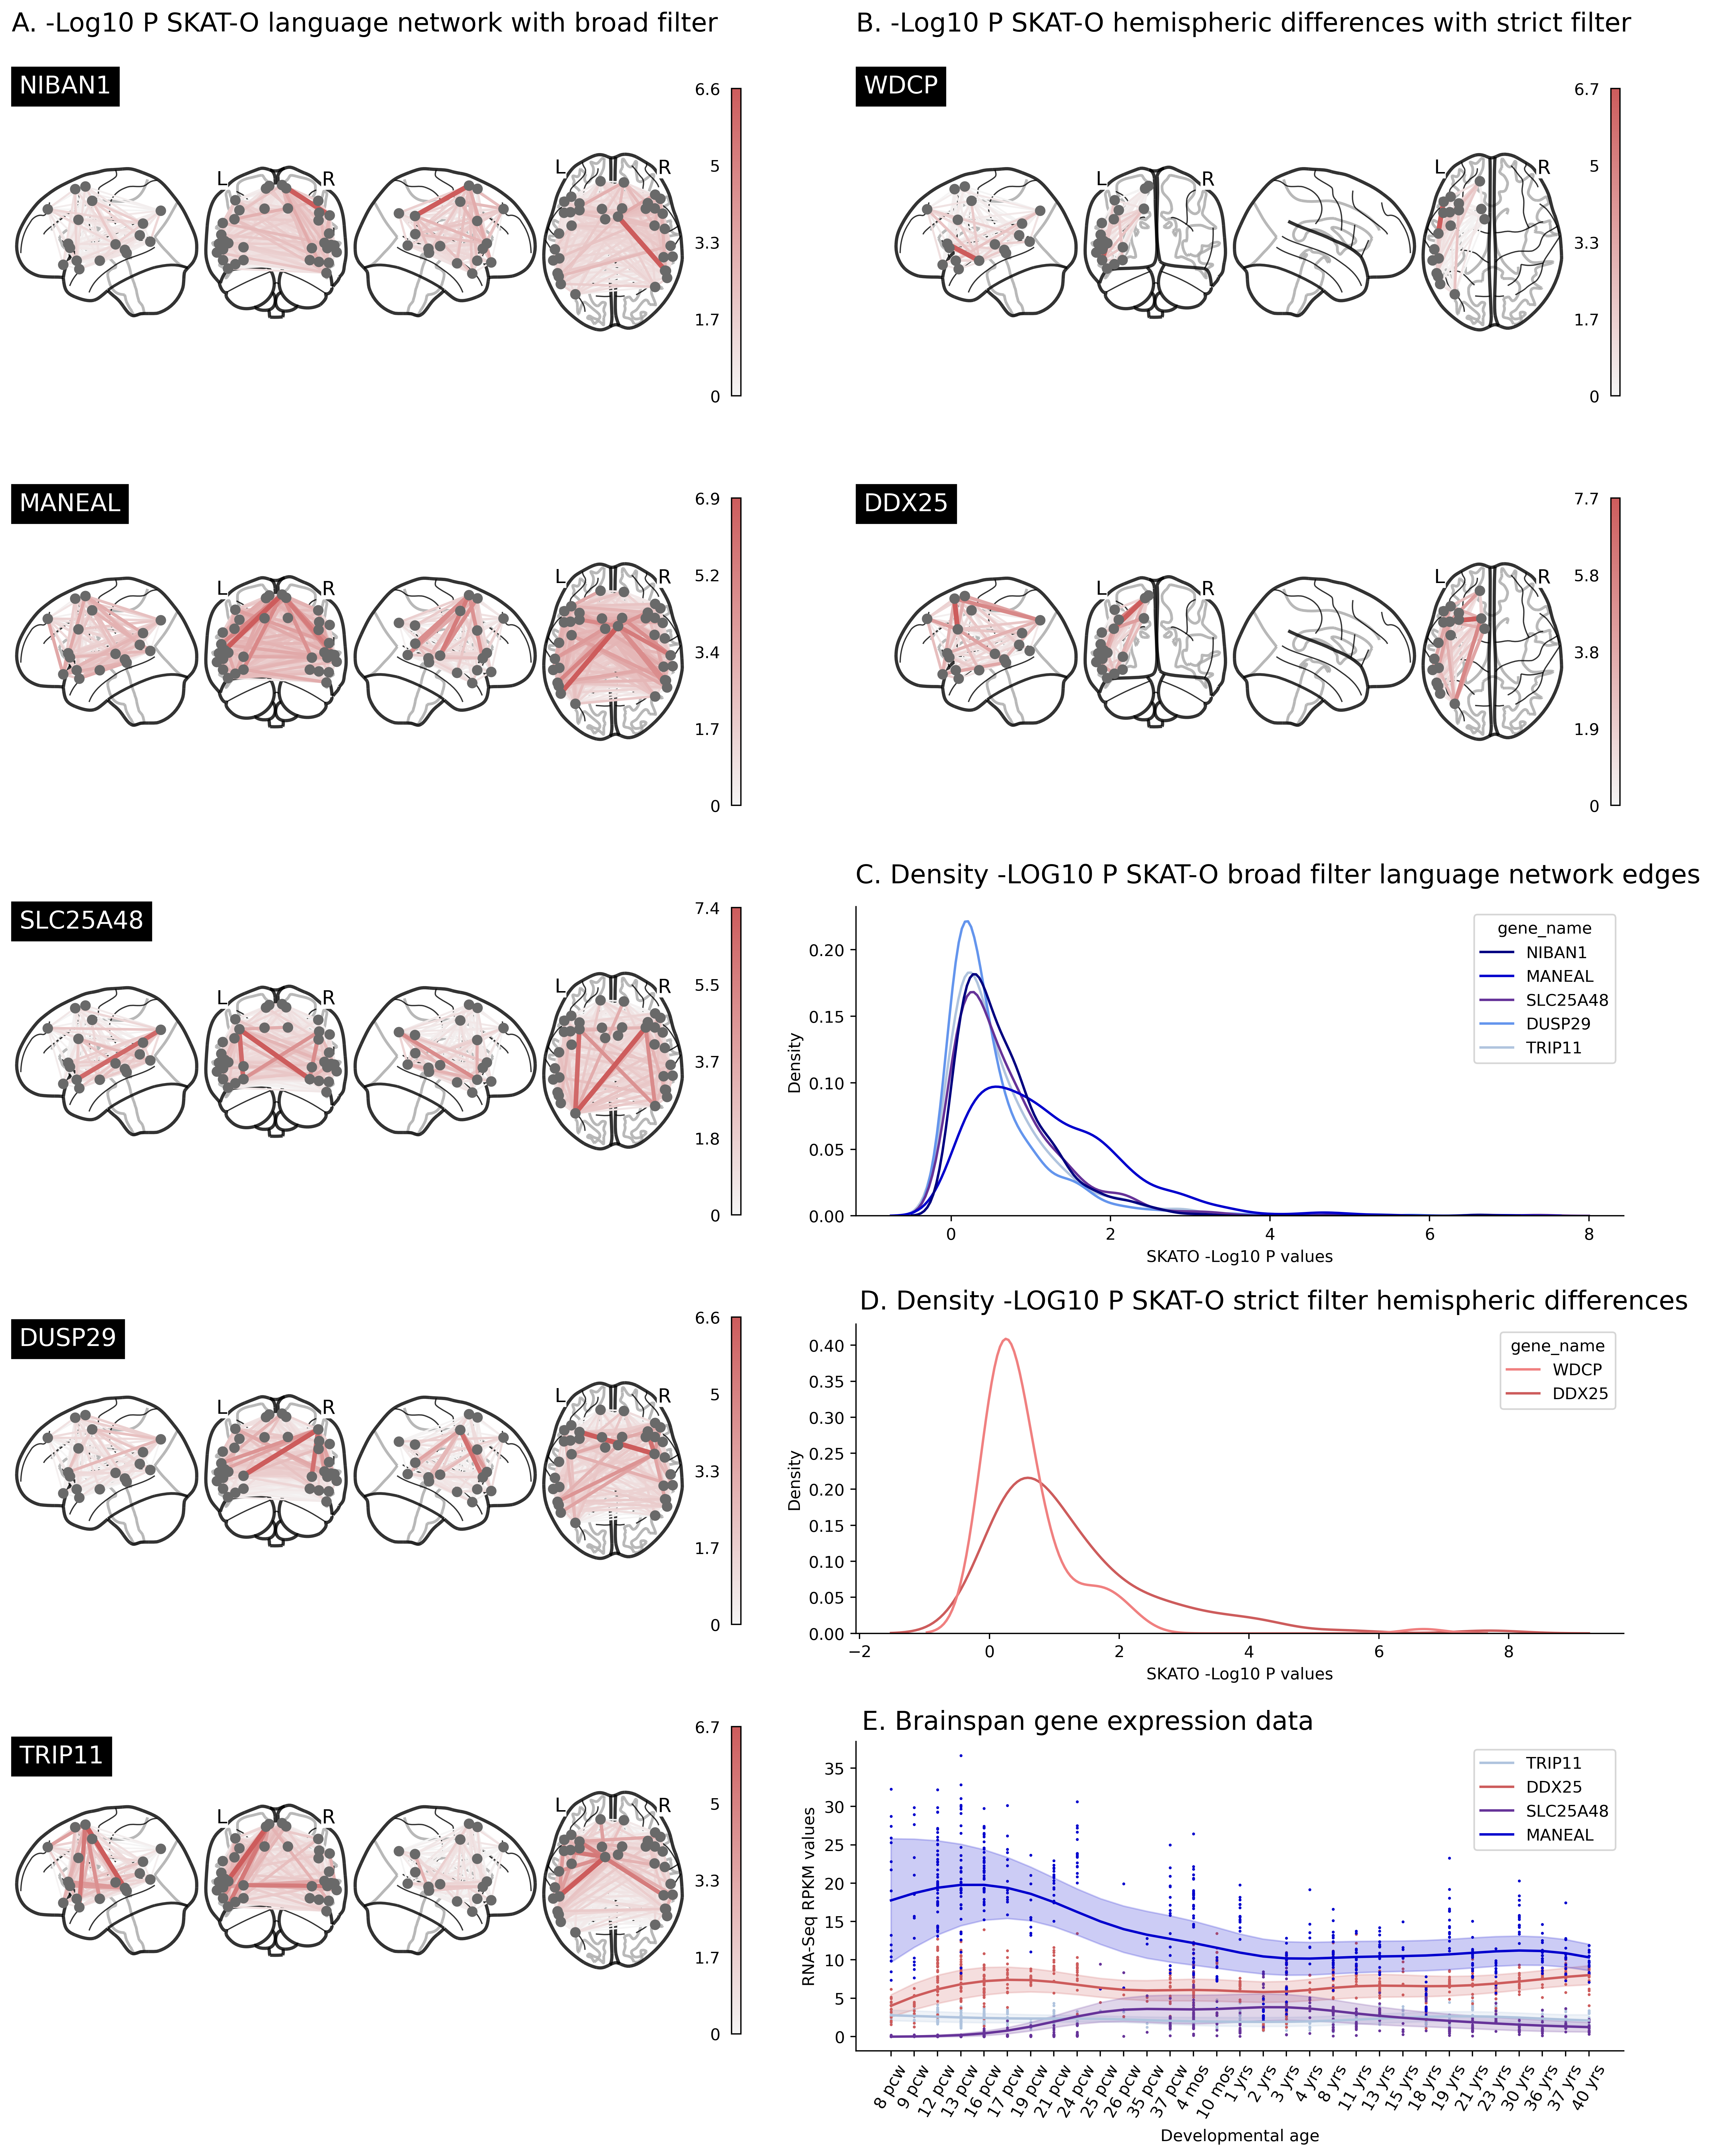

In [16]:
fig_args = {"figsize":(17.8,22),"dpi":400} 
            # NIBAN1    MANEAL       SLC25A48          DUSP29            TRIP11
colors_lang = ["navy", "mediumblue", "rebeccapurple", "cornflowerblue", "lightsteelblue"]
            # WDCP            DDX25
colors_asym = ["lightcoral", "indianred"]
             #TRIP11           DDX25          SLC25A48      MANEAL
colors_bs = ["lightsteelblue", "indianred",  "rebeccapurple", "mediumblue"]



vmax_in = None #float(7.7)

fig, ax = plt.subplots(5, 2, gridspec_kw={'height_ratios': [1]*len(p_df_broad)}, **fig_args)

#plot language network results
for x, gene in enumerate(p_df_broad.index.values):
    plot_results_brain_betas(betas=p_df_broad,
                             pvals=p_df_broad,
                             cat="edges",
                             ax=ax[x, 0],
                             title=gene,
                             snp=gene,
                             vmax_in=vmax_in,
                            rare=True)

#plot hemispheric differences
for x, gene in enumerate(p_df_strict.index.values):
    plot_results_brain_betas(betas=p_df_strict,
                             pvals=p_df_strict,
                             cat="edges_HD",
                             ax=ax[x, 1],
                             title=gene,
                             snp=gene,
                             vmax_in=vmax_in,
                             rare=True)

#plot densities
sns.kdeplot(p_df_broad.T, ax=ax[2,1], palette=colors_lang)
sns.kdeplot(p_df_strict.T, ax=ax[3,1], palette=colors_asym)
ax[2,1].set_xlabel("SKATO -Log10 P values")
ax[3,1].set_xlabel("SKATO -Log10 P values")

#plot brainspan expression data
plot_brainspan(data_bs,
               genes_bs,
               age_columns,
               colors_bs,
               ax[4,1],
               bw=[2.5])

#adjust spacing
plt.subplots_adjust(hspace=0.35, wspace=0.1)

#set spines
ax[2,1].spines["top"].set_visible(False)
ax[2,1].spines["right"].set_visible(False)
ax[2,1].spines["left"].set_visible(True)
ax[2,1].spines["bottom"].set_visible(True)
ax[3,1].spines["top"].set_visible(False)
ax[3,1].spines["right"].set_visible(False)
ax[3,1].spines["left"].set_visible(True)
ax[3,1].spines["bottom"].set_visible(True)
ax[4,1].spines["top"].set_visible(False)
ax[4,1].spines["right"].set_visible(False)
ax[4,1].spines["left"].set_visible(True)
ax[4,1].spines["bottom"].set_visible(True)

#titles
#fig.suptitle("Rare variant results", y=0.93, fontsize=28)
ax[0, 0].text(0, 1.13, "A. -Log10 P SKAT-O language network with broad filter", fontsize=16)
ax[0, 1].text(0, 1.13, "B. -Log10 P SKAT-O hemispheric differences with strict filter", fontsize=16)
ax[2,1].text(-1.2, 0.25, "C. Density -LOG10 P SKAT-O broad filter language network edges", fontsize=16)
ax[3,1].text(-2, 0.45, "D. Density -LOG10 P SKAT-O strict filter hemispheric differences", fontsize=16)
ax[4,1].text(-1.25, 40, "E. Brainspan gene expression data", fontsize=16)

plt.savefig(fname=os.path.join(plot_path, "Fig_3_rare_variant_results_v4.eps"), bbox_inches="tight")
plt.savefig(fname=os.path.join(plot_path, "Fig_3_rare_variant_results_v4.tif"), bbox_inches="tight")
plt.savefig(fname=os.path.join(plot_path, "Fig_3_rare_variant_results_v4.png"), bbox_inches="tight")

